<a href="https://colab.research.google.com/github/AndreassOlsson/drone-anomalydetection/blob/main/SpatioTemporal_VisionTransformer_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import BCELoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import matplotlib.pyplot as plt

import random
import cv2
import copy
import bisect
import math
import itertools

np.random.seed(42)
torch.manual_seed(42)

%matplotlib inline

We will simulate video data by stacking multiple MNIST images on top of each other. This is just for playing around with the implementation of future video data and does (probably) not have a practical use

Parameters include:
* Patch size
* Number of transformer layers
* Number of attention heads
* MLP size
* Number of input frames

Compared to other anomaly detection strategies, inputing 6 consecutive frames and predicting the next frame yielded the best results. Note that I am not entirely sure about every single detail of this method but this is the current plan:
* For training, the model will take 6 mnist images of the same number as input and a singel mnist image of the same number as target and measure performance with Binary Cross Entropy Loss
* For testing, the model will take 6 mnist images and try to reconstruct the number. We will measure the l2 distance between the prediction and an actual image of the "normal" number



# Prepare data

In [ ]:
mnist_train = MNIST(root='./mnist', train=True, download=True, transform=ToTensor()) 
mnist_test = MNIST(root='./mnist', train=False, download=True, transform=ToTensor()) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [ ]:
# "This is only for demonstrational purposes and only uses the labels of the dataset, not the actual images"
# lbls = list(set([i[1] for i in mnist_test]))
# lbl2lbls = {lbl:[i[1] for i in mnist_test if i[1] == lbl] for lbl in lbls}
# normal_patterns = [[f'lbl:{lbl2lbls[n][0]} idx:{i}' for n in range(len(lbls))] for i in range(min([len(l) for l in lbl2lbls.values()]))]; normal_patterns[-1]

# "Randomly cut every list in values to a length of 6 + 1"
# def random_slice_demo(l):
#   start = random.randint(0,10); end = start + 7
#   if end >= 10: 
#     end = end % 10
#     l = l[start:] + l[:end]
#   else:
#     l = l[start:end]
#   return (l[:-1], l[-1])

# normal_sequences = list(map(random_slice_demo, normal_patterns)); normal_sequences[-1]

In [ ]:
"Randomly cut every list in values to a length of 6 + 1"
def random_slice(l):
  start = random.randint(0,10); end = start + 7
  if end >= 10: 
    end = end % 10
    l = l[start:] + l[:end]
  else:
    l = l[start:end]
  return (torch.stack(tuple(l[:-1])), l[-1])

In [ ]:
class SpatioTemporal_MNIST(Dataset):
  def __init__(self, mnist):
    """
    Input = 6 consecutive "frames" of video V = {I1,I2,...,I6}, in this case 6 images of the same mnist number
    Target = 1 frame, I6+1, in this case 1 image of the same mnist number
    Therefor our "videos" of a number must be devisible by 6+1=7

    A normal pattern is an increament of 1 like {0, 1, 2, 3, 4, 5 - 6} or {6, 7, 8, 9, 0, 1 - 2}
    
    In {0, 1, 2, 3, 4, 5 - 3} the observation is a 3 and the model would have predicted a 6 -> Anomaly
    In {0, 1, 2, 3, 4, 5 - 9} the observation is a 9 and the model would have predicted a 6 -> Anomaly

    If the l2 distance between the prediction and observation is relatively big it is considered abnormal

    A testing video where each frame is either normal, 0, or abnormal, 1, might look like this:
    {1:0, 2:0, 3:0, 3:1, 5:0, 6:0, 7:0, 8:0, 9:0, 0:0, 2:1, 2:0, 3:0, 4:0, 5:0, 6:0, 4:1, 8:0}
    """
    lbls = list(set([i[1] for i in mnist]))
    lbl2imgs = {lbl:[i[0] for i in mnist if i[1] == lbl] for lbl in lbls}
    normal_patterns = [[lbl2imgs[n][i] for n in range(len(lbls))] for i in range(min([len(l) for l in lbl2imgs.values()]))]
    self.dset = list(map(random_slice, normal_patterns))

  def __getitem__(self, idx):
    return self.dset[idx]

  def __len__(self):
    return len(self.dset)

  def show(self, idx):
    f, axs = plt.subplots(1,7, figsize=(21,3))
    data = self.dset[idx][0]
    target = self.dset[idx][1]

    for i in range(7):
      if i == 6: img = target
      else: img = data[i]
      im_cv = img.numpy().transpose(1,2,0).squeeze()
      im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
      axs[i].title.set_text(f'Input frame {i+1}' if not i==6 else 'Target frame')
      axs[i].imshow(im_rgb)

    plt.imshow(im_rgb)

In [ ]:
train_dset = SpatioTemporal_MNIST(mnist_train)
test_dset = SpatioTemporal_MNIST(mnist_test)

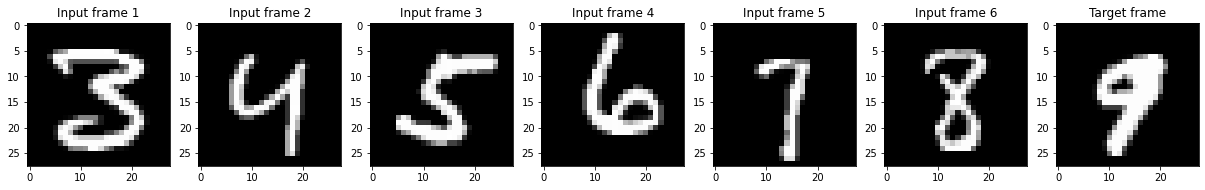

In [ ]:
train_dset.show(random.randint(0,len(train_dset)))

In [ ]:
train_dl = DataLoader(train_dset, shuffle=True, batch_size=128)
test_dl = DataLoader(test_dset, shuffle=False, batch_size=128)

# Create model class

In [ ]:
class SpatioTemporal_AE(nn.Module):
  def __init__(self, encoder, decoder):
    super(SpatioTemporal_AE, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, videos):
    encoded_input = self.encoder(videos)
    decoded_output = self.decoder(encoded_input)
    return decoded_output

## Encoder

The encoder will take as input:
1. The sequence of tubelets (patches) mapped into tubelet embeddings via a linear projection
 1. Tubelets = *x_k*
 2. Weights of trainable linear projection = *E* 
2. An extra learnable embedding prepended to the sequence of tubelet embeddings
 1. Learnable embedding = *x_cls*
3. Learnable spatiotemporal embeddings added to the tubelet embeddings
 1. Learnable spatiotemporal position embeddings = *E_pos*

Encoder input = [*x_cls*; *x_k_1* * *E*; *x_k_2* * *E*; ... ; *x_k_N* * *E*] + E_pos

In [ ]:
# PyTorch requires images to be in N C H W format
# Apperently this method with nested for loops was faster than nested list comprehensions
def patchify(batch, patch_thw=(3,4,4)):
  N, T, C, H, W = batch.shape
  t, h, w = patch_thw

  assert T % t == 0, 'Number of videoframes is not divisible by the number of frames in each patch'
  assert H % h == 0, 'Videoframe height is not divisible by patch height'
  assert W % w == 0, 'Videoframe width is not divisible by patch width'

  patches = []
  for video in batch:
    video_patches = []
    for f in range(T//t):
      for y in range(H//h):
        for x in range(W//w):
          video_patches.append(video[f*t:(f+1)*t, :, y*h:(y+1)*h, x*w:(x+1)*w].flatten())
          # print(f'Patch {len(patches)}:\t Video {i}\t Frames {f*t}:{(f+1)*t}\t Channels :\t Rows {y*h}:{(y+1)*h}\t Columns {x*w}:{(x+1)*w}')
    
    patches.append(torch.stack(tuple(video_patches)))
  return torch.stack(tuple(patches))


# Test function
sample_batch = torch.rand(7,6,1,28,28)
N, T, C, H, W = sample_batch.shape 
t, h, w = 3, 4, 4

patches = patchify(sample_batch, patch_thw=(t,h,w))

assert patches.shape == (N, (H/h * W/w) * (T/t), t*C*h*w)

patches.shape

torch.Size([7, 98, 48])

In [ ]:
"Multi-head Self Attention"
class Linear(nn.Module):
  def __init__(self, input_dim=(768,), output_dim=(6, 768//6)):
    super(Linear, self).__init__()

    self.weight = nn.Parameter(torch.randn(*input_dim, *output_dim))
    self.bias = nn.Parameter(torch.randn(*output_dim))

  def forward(self, x, dims):
    return torch.tensordot(x, self.weight, dims=dims) + self.bias


class Multihead_Self_Attention(nn.Module):
  def __init__(self, input_dim=768, n_attention_heads=6):
    super(Multihead_Self_Attention, self).__init__()

    self.input_dim, self.n_attention_heads = input_dim, n_attention_heads

    assert input_dim % n_attention_heads == 0, f'Input dimension is not divisible by number of attention heads'
    
    self.head_dim = input_dim // n_attention_heads

    self.query = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.key = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.value = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.out = Linear(input_dim=(n_attention_heads, self.head_dim), output_dim=(input_dim,))
    
  def forward(self, x):
    # (N, n_embeddings, embedding_dim) --> (N, n_embeddings, n_attention_heads, head_dim) --> (N, n_embeddings, embedding_dim)

    query = self.query(x, dims=([2], [0])).permute(0, 2, 1, 3)
    key = self.key(x, dims=([2], [0])).permute(0, 2, 1, 3)
    value = self.value(x, dims=([2], [0])).permute(0, 2, 1, 3)

    attn_weights = torch.matmul(query, key.transpose(-2,-1)) / self.head_dim ** 0.5
    attn_weights = F.softmax(attn_weights, dim=-1)

    out = torch.matmul(attn_weights, value).permute(0, 2, 1, 3)

    return self.out(out, dims=([2,3],[0,1]))

Multihead_Self_Attention()(torch.randn(7, 99, 768)).shape

torch.Size([7, 99, 768])

In [ ]:
class VisionTransformer_block(nn.Module):
  def __init__(self, input_dim=768, mlp_dim=4096, n_attention_heads=6):
    super(VisionTransformer_block, self).__init__()

    self.norm1 = nn.LayerNorm(input_dim)
    self.attention = Multihead_Self_Attention(input_dim, n_attention_heads)
    self.dropout = nn.Dropout(0.1)
    self.norm2 = nn.LayerNorm(input_dim)
    self.mlp = nn.Sequential(
        nn.Linear(input_dim, mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim, input_dim)
    )

  def forward(self, x):
    residual = x
    out = self.norm1(x)
    out = self.attention(x)
    out = self.dropout(out)
    out = out + residual

    residual = out
    out = self.norm2(out)
    out = self.mlp(out)
    out = out + residual

    return out

VisionTransformer_block()(torch.randn(7, 99, 768)).shape

torch.Size([7, 99, 768])

In [ ]:
class SpatioTemporal_Encoder(nn.Module):
  def __init__(self, video_dim=(6,1,28,28), patch_dim=(3,4,4), embedding_dim=196, mlp_dim=392, n_attention_heads=2, n_transformer_layers=2):
    super(SpatioTemporal_Encoder, self).__init__()

    self.video_dim, self.patch_dim = video_dim, patch_dim
    self.embedding_dim, self.mlp_dim = embedding_dim, mlp_dim
    self.n_attention_heads, self.n_transformer_layers = n_attention_heads, n_transformer_layers

    assert embedding_dim % n_attention_heads == 0, 'Embedding dimension is not divisible by number of attention heads in the transformer'

    T, C, H, W = self.video_dim
    t, h, w = self.patch_dim
    self.n_patches = (H//h * W//w) * (T//t)

    assert T % t == 0, 'Number of videoframes is not divisible by the number of frames in each patch'
    assert H % h == 0, 'Videoframe height is not divisible by patch height'
    assert W % w == 0, 'Videoframe width is not divisible by patch width'

    self.dropout = nn.Dropout(0.1)

    # 1) Linear projection, tubelets = xk_n, weights = E
    self.input_dim = int(t * C * h * w)
    self.linear_projection = nn.Linear(self.input_dim, self.embedding_dim)

    # 2) Extra learnable embedding, x_cls
    self.extra_learnable_embedding = nn.Parameter(torch.zeros(1, 1, self.embedding_dim))

    # 3) Learnable spatiotemporal embedding, E_pos
    self.spatiotemporal_embedding = nn.Parameter(torch.randn(1, (H//h * W//w) * (T//t) + 1, self.embedding_dim))

    # 4) Transformer
    self.transformer_layers = nn.ModuleList([VisionTransformer_block(self.embedding_dim, self.mlp_dim, self.n_attention_heads) for _ in range(self.n_transformer_layers)])
    self.norm = nn.LayerNorm(self.embedding_dim)

    # 5) Map extra learnable embedding to output dim
    # self.output = nn.Linear(((H//h * W//w) * (T//t) + 1) * self.embedding_dim, out_dim) 
    # self.output = nn.Linear(embedding_dim, out_dim) 


    
  def forward(self, videos):
    N, T, C, H, W = videos.shape
    t, h, w = self.patch_dim

    tubelets = patchify(batch=videos, patch_thw=(t,h,w)) 
    tubelet_embeddings = self.linear_projection(tubelets)
    tubelet_embeddings = self.dropout(tubelet_embeddings)
  
    extra_embedding = self.extra_learnable_embedding.repeat(N, 1, 1)
    extra_embedding = self.dropout(extra_embedding)

    embeddings = torch.cat([extra_embedding, tubelet_embeddings], dim=1)
    out = embeddings + self.spatiotemporal_embedding

    for transformer_layer in self.transformer_layers:
      out = transformer_layer(out)
 
    # out = out.view(N, ((H//h * W//w) * (T//t) + 1) * self.embedding_dim) # v2
    # out = out[:,0] # The prepended extra learnable embedding will serve as the output from the encoder v1
    # out  = self.output(out)
    # out = self.dropout(out)

    return self.norm(out)

out = SpatioTemporal_Encoder()(torch.randn(7,6,1,28,28)); out.shape

torch.Size([7, 99, 196])

## Decoder

In [ ]:
class SpatioTemporal_Decoder(nn.Module):
  def __init__(self, input_dim=(99, 196), hw=(7, 7)):
    super(SpatioTemporal_Decoder, self).__init__()

    self.hw = hw
    input_channels = input_dim[0] * input_dim[1] // (hw[0] * hw[1])

    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(input_channels, 256, 2, stride=2, padding=0),
      nn.BatchNorm2d(256),
      nn.ReLU(),

      nn.Conv2d(256, 128, 3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      
      nn.Conv2d(128, 64, 3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
  
      nn.ConvTranspose2d(64, 64, 2, stride=2, padding=0),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.Conv2d(64, 32, 3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),

      nn.Conv2d(32, 1, 3, stride=1, padding=1),
      nn.Sigmoid()
    )
    
  def forward(self, x):
    out = x.view(x.shape[0], (x.shape[1] * x.shape[2] // (self.hw[0] * self.hw[1])), self.hw[0], self.hw[1])
    out = self.decoder(out)
    return out

out = SpatioTemporal_Decoder(hw=(7,7))(torch.rand(7, 99, 196)); out.shape

torch.Size([7, 1, 28, 28])

# Train model

In [ ]:
model_name = 'SpatioTemporal_VisionTransformer_AutoEncoder_v3.pth'
state_dict_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/' + model_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Model name: {model_name}, Using device {device}')

Model name: SpatioTemporal_VisionTransformer_AutoEncoder_v3.pth, Using device cpu


## Training loop (remember to call before new version)

In [ ]:
def train_epochs(epochs=5):
  print(f'{"-"*20}Training model {model_name} for {epochs} epochs with {trainable_params:_} trainable params and learning rate of {lr}{"-"*20}\n')
  min_test_loss = np.inf
  for epoch in range(epochs):
    train_epoch_loss = 0.
    model.train()
    for batch in tqdm(train_dl, desc=f'Training Epoch: [{epoch + 1} ---> {epochs}]', position=0, leave=True):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)

      train_loss = criterion(y_hat, y)
      train_epoch_loss += train_loss.detach().cpu().item() / len(train_dl)

      optim.zero_grad()
      train_loss.backward()
      optim.step()

    with torch.no_grad():
      test_epoch_loss = 0
      model.eval()
      for batch in tqdm(test_dl, desc=f'Testing Epoch [{epoch + 1} ---> {epochs}]', position=0, leave=True):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)

        test_loss = criterion(y_hat, y)
        test_epoch_loss += test_loss.detach().cpu().item() / len(test_dl)

      print(f'[Epoch {epoch + 1}]\tTrain loss: {train_epoch_loss:.4f}\tTest loss {test_epoch_loss:.4f}')

      if test_epoch_loss < min_test_loss:
        print(f'Test loss decreased ({min_test_loss:.4f}--->{test_epoch_loss:.4f})\tSaving the model...\n')
        min_test_loss = test_epoch_loss
        torch.save(model.state_dict(), state_dict_path)
      else: print('')

## Instantiate model (model parameters)

v1 (encoder outputs extra learnable embedding mapped to a linear projection): 
* embed_dim = 64, mlp_dim = 128, patch_dim = (3,4,4), n_heads = 2, n_layers = 1, output_dim = 245, input_hw = (7,7)
* BCELoss of 0.2377

v2 (encoder outputs only extra learnable embedding):

In [ ]:
def valid_embed_dims(n_max=1000, n_attention_heads=None, must_match=(7,7)):
  n_attention_heads = [n_attention_heads] if n_attention_heads else list(range(1,10))  
  return {n: [i for i in range(1, n_max + 1) if i % n == 0 and (1 / (must_match[0] * must_match[1] / i)) % 1 == 0] for n in n_attention_heads}

for k,v in valid_embed_dims().items(): print('n_heads:',k,v)

n_heads: 1 [49, 98, 147, 196, 245, 294, 343, 392, 441, 490, 539, 588, 637, 686, 735, 784, 833, 882, 931, 980]
n_heads: 2 [98, 196, 294, 392, 490, 588, 686, 784, 882, 980]
n_heads: 3 [147, 294, 441, 588, 735, 882]
n_heads: 4 [196, 392, 588, 784, 980]
n_heads: 5 [245, 490, 735, 980]
n_heads: 6 [294, 588, 882]
n_heads: 7 [49, 98, 147, 196, 245, 294, 343, 392, 441, 490, 539, 588, 637, 686, 735, 784, 833, 882, 931, 980]
n_heads: 8 [392, 784]
n_heads: 9 [441, 882]


In [ ]:
video_dim = (6,1,28,28)
patch_dim = (3,4,4)

# Encoder params
embed_dim = 196
mlp_dim = embed_dim * 4
n_attention_heads = 7
n_transformer_layers = 2

# Decoder
decoder_input_hw = (7, 7)
n_embeds = (video_dim[2]//patch_dim[1] * video_dim[3]//patch_dim[2]) * video_dim[0]//patch_dim[0] + 1

encoder = SpatioTemporal_Encoder(video_dim=video_dim, patch_dim=patch_dim, embedding_dim=embed_dim, mlp_dim=mlp_dim, n_attention_heads=n_attention_heads, n_transformer_layers=n_transformer_layers).to(device)
decoder = SpatioTemporal_Decoder(input_dim=(n_embeds, embed_dim), hw=decoder_input_hw).to(device)
model = SpatioTemporal_AE(encoder, decoder).to(device)


print('-'*20,model_name,'-'*20)
print(f'Encoder params:\nEmbed_dim:{embed_dim}, mlp_dim:{mlp_dim}, patch_dim:{patch_dim}, n_attention_heads:{n_attention_heads}, n_transformer_layers:{n_transformer_layers}\n')
print(f'Decoder params:\ninput_dim:{n_embeds, embed_dim}, hw={decoder_input_hw}\n')

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in trainable_params])
print(f'Trainable params: {trainable_params:_}\n')

sample_input = torch.rand(7, 6, 1, 28, 28).to(device)
sample_output = model(sample_input)
print(f'Sample input shape: {sample_input.shape}\nSample output shape: {sample_output.shape}')
print(f'Sample output values ranging from {torch.min(sample_output).item():.5f} to {torch.max(sample_output).item():.5f}\n')

try:
  model_weights = 'SpatioTemporal_VisionTransformer_AutoEncoder_v3.pth'
  pretrained_weights_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/' + model_weights
  model.load_state_dict(torch.load(pretrained_weights_path, map_location=torch.device(device)), strict=False)
  print('Pretrained weights loaded sucessfully\n')
except:
  print('Could not load pretrained weights\n')

torch.cuda.empty_cache()

-------------------- SpatioTemporal_VisionTransformer_AutoEncoder_v3.pth --------------------
Encoder params:
Embed_dim:196, mlp_dim:784, patch_dim:(3, 4, 4), n_attention_heads:7, n_transformer_layers:2

Decoder params:
input_dim:(99, 196), hw=(7, 7)

Trainable params: 1_767_557

Sample input shape: torch.Size([7, 6, 1, 28, 28])
Sample output shape: torch.Size([7, 1, 28, 28])
Sample output values ranging from 0.16267 to 0.74003

Pretrained weights loaded sucessfully



## Train model (training parameters)

In [ ]:
momentum = 0.9
lr = 5e-3
epochs = 6

optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optim = Adam(model.parameters(), lr=lr)
criterion = BCELoss()

train_epochs(epochs)

# Test model

## Test performance

In [ ]:
criterion = BCELoss()

In [ ]:
print(f'{"-"*20}Testing model {model_name}{"-"*20}\n')

with torch.no_grad():
  test_epoch_loss = 0
  model.eval()
  for batch in tqdm(test_dl, desc=f'Testing', position=0, leave=True):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)

    test_loss = criterion(y_hat, y)
    test_epoch_loss += test_loss.detach().cpu().item() / len(test_dl)

  print(f' ---> Test loss: {test_epoch_loss:.4f}')

--------------------Testing model SpatioTemporal_VisionTransformer_AutoEncoder_v3.pth--------------------



Testing: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

 ---> Test loss: 0.2378


## Perform inference

In [ ]:
def show_preds(n=2):
  for _ in range(n):
    f, axs = plt.subplots(1, 8, figsize=(21, 3))

    data = random.choice(test_dl.dataset)
    input = data[0].to(device)
    target = data[1].to(device)
    pred = model(input.unsqueeze(0).to(device)).squeeze()

    for i in range(8):
      if i == 6: img = pred
      elif i == 7: img = target
      else: img = input[i]
      im_cv = img.cpu().detach().numpy().squeeze()
      im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
      axs[i].title.set_text('Predicted frame 7' if i==6 else 'Observed frame 7' if i==7 else f'Input frame {i+1}')
      axs[i].imshow(im_rgb)

    plt.imshow(im_rgb)

show_preds()

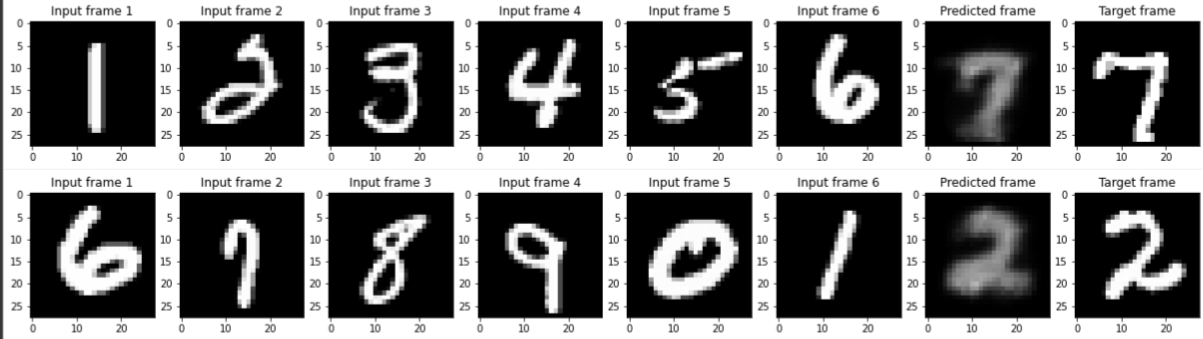